In [1]:
import numpy as np
import pickle

In [2]:
#State Represenation
class State:
    def __init__(self,player1, player2,rows = 3, columns = 3):
        self.rows = rows
        self.columns = columns
        self.board = np.zeros((self.rows, self.columns))                
        self.board_array = None
        self.player1 = player1
        self.player2 = player2
        self.done = False
        
        #The first player will be represented as 1 and Player 2 will have -1 representation
        
        self.player_mark = 1
        
    
    
    def showBoard(self):
        for i in range(self.rows):
            print('-------------')
            out = '| '
            for j in range(0, self.columns):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')
    
    def convertBoardToArray(self):
        self.board_array = str(self.board.reshape(self.rows * self.columns))
        return self.board_array
    
    def availablePosition(self):
        a = []
        for i in range(self.rows):
            for j in range(self.columns):
                if self.board[i,j] == 0:
                    a.append((i,j))
        return a
    
    def Win(self):
        
        for i in range(self.rows):
            if sum(self.board[i, :]) == 3:
                self.done = True
                return 1
            if sum(self.board[i, :]) == -3:
                self.done = True
                return -1
        for j in range(self.columns):
            if sum(self.board[:,j]) == 3:
                self.done = True
                return 1
            if sum(self.board[:,j]) == -3:
                self.done = True
                return -1
        #Diagonals
        diagonal1 = sum([self.board[i, i] for i in range(self.columns)])
        diagonal2 = sum([self.board[i, self.columns-i-1] for i in range(self.columns)])
        if diagonal1 == 3 or diagonal2 == 3:
            self.done = True
            return 1
        if diagonal1 == -3 or diagonal2 == -3:
            self.done = True
            return -1
        
        isTie = self.Tie()
        if isTie == 0:
            return isTie
        self.done = False
        return None
    
    def Tie(self):
        if (len(self.availablePosition())) == 0:
            self.done = True
            return 0
        
    def ToggleSymbol(self):
        self.player_mark = -self.player_mark
    
    def updateState(self, position):
        self.board[position] = self.player_mark
        if self.player_mark == 1:
            self.player_mark = -1
        else:
            self.player_mark = 1
    
    def reward(self):
        win = self.Win()
        if win == 1:
            self.player1.giveReward(1)
            self.player2.giveReward(-1)
        elif win == -1:
            self.player1.giveReward(-1)
            self.player2.giveReward(1)
        else:
            self.player1.giveReward(0.1)
            self.player2.giveReward(0.5)
    
    def train(self, number_of_rounds = 100000):
        for i in range(number_of_rounds):
            if i % 1000000 == 0:
                print("Round number:", i)
            while not self.done:
                if np.random.uniform(0,1) <= 0.1:
                    self.ToggleSymbol()
                else:
                    available_positions = self.availablePosition()
                    action1 = self.player1.selectAction(available_positions, self.board, self.player_mark)
                    self.updateState(action1)
                    boardArray = self.convertBoardToArray()
                    self.player1.addState(boardArray)
                    win = self.Win()
                    if win is not None:
                        self.reward()
                        self.player1.reset()
                        self.player2.reset()
                        self.reset()
                        break
                if np.random.uniform(0,1) <= 0.1:
                    self.ToggleSymbol()
                else:
                    available_positions = self.availablePosition()
                    action2 = self.player2.selectAction(available_positions, self.board, self.player_mark)
                    self.updateState(action2)
                    boardArray1 = self.convertBoardToArray()
                    self.player2.addState(boardArray1)
                    win = self.Win()
                    if win is not None:
                        self.reward()
                        self.player1.reset()
                        self.player2.reset()
                        self.reset()
                        break
    
    def playwithHuman(self):
        while not self.done:
            available_positions = self.availablePosition()
            action1 = self.player1.selectAction(available_positions, self.board, self.player_mark)
            self.updateState(action1)
            boardArray = self.convertBoardToArray()
#             self.player1.addState(boardArray)
            self.showBoard()
            win = self.Win()
            if win is not None:
                if win == 1:
                    print(self.player1.name, "wins!")
                else:
                    print("tie!")
                self.reset()
                break
            else:
                available_positions = self.availablePosition()
                action2 = self.player2.selectAction(available_positions)
                self.updateState(action2)
                boardArray1 = self.convertBoardToArray()
#                 self.player2.addState(boardArray1)
                self.showBoard()
                win = self.Win()
                if win is not None:
                    if win == -1:
                        print(self.player2.name, "wins!")
                    else:
                        print("tie!")
                    self.reset()
                    break

            
                    
    
    
    def reset(self):
        self.board = np.zeros((self.rows, self.columns))
        self.board_array = None
        self.done = False
        self.player_mark = 1
        
        

In [3]:
class Agent():
    def __init__(self,name,epsilon = 0.3,rows=3, columns=3):
        self.name = name
        self.rows = rows
        self.columns = columns
        self.alpha = 0.2
        self.gamma = 0.9
        self.epsilon = epsilon
        self.states_value = {}
        self.state_list = []
        self.sum_of_qvalues = []
        
    def convertBoardToArray(self, board):
        board_array = str(board.reshape(self.rows * self.columns))
        return board_array
    
    def addState(self, state):
        self.state_list.append(state)
    
    def selectAction(self,position_available, board, player_mark):
        if np.random.uniform(0,1) <= self.epsilon:
            index = np.random.choice(len(position_available))
            action = position_available[index]
        else:
            value_max = -999
            for p in position_available:
                next_board = board.copy()
                next_board[p] = player_mark
                next_board_Array = self.convertBoardToArray(next_board)
                if self.states_value.get(next_board_Array) is None:
                    value = 0
                else:
                    value = self.states_value.get(next_board_Array)
     
                if value >= value_max:
                    value_max = value
                    action = p
        return action
    
    def giveReward(self, reward):
        for i in reversed(self.state_list):
            if self.states_value.get(i) is None:
                self.states_value[i] = 0
            self.states_value[i] += self.alpha * (self.gamma * reward - self.states_value[i])
            reward = self.states_value[i]
        self.sum_of_qvalues.append(sum(self.states_value.values()))
        
    def reset(self):
        self.state_list = []
    
    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()
    
    def loadPolicy(self, file):
        fr = open(file,'rb')
        self.states_value = pickle.load(fr)
        fr.close()    

        


In [4]:
class Human:
    def __init__(self, name):
        self.name = name
    def selectAction(self,position):
        while True:
            r = int(input("Input your action row(range:0 to 2)"))
            c = int(input("Input your action column(range:0 to 2):"))
            action = (r,c)
            if action in position:
                return action
            

In [5]:
p1 = Agent("p1")
st = State(p1, p1)
print("Training...")
st.train(1000000)

Training...
Round number: 0


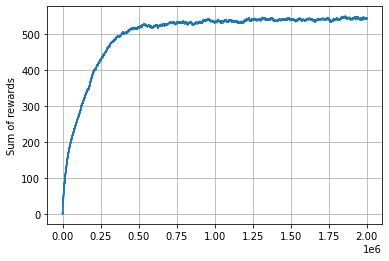

In [6]:
import matplotlib.pyplot as plt
plt.plot(p1.sum_of_qvalues)
plt.ylabel('Sum of rewards')
plt.grid(True)
plt.savefig("Graph.png")
plt.show()

In [7]:
p1.savePolicy()

In [8]:
p1.loadPolicy("policy_p1")

In [10]:
p1 = Agent("computer", epsilon=0)
p1.loadPolicy("policy_p1")

p2 = Human("human")

st = State(p1, p2)
st.playwithHuman()

-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
|   |   | x | 
-------------
Input your action row(range:0 to 2)2
Input your action column(range:0 to 2):0
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
| o |   | x | 
-------------
-------------
|   |   | x | 
-------------
|   |   |   | 
-------------
| o |   | x | 
-------------
Input your action row(range:0 to 2)1
Input your action column(range:0 to 2):2
-------------
|   |   | x | 
-------------
|   |   | o | 
-------------
| o |   | x | 
-------------
-------------
|   |   | x | 
-------------
| x |   | o | 
-------------
| o |   | x | 
-------------
Input your action row(range:0 to 2)0
Input your action column(range:0 to 2):1
-------------
|   | o | x | 
-------------
| x |   | o | 
-------------
| o |   | x | 
-------------
-------------
|   | o | x | 
-------------
| x |   | o | 
-------------
| o | x | x | 
-------------
Input your action row(range:0 to 2)1
Input your action colu